In [93]:
import sys

import torch  # noqa: E402
import random  # noqa: E402
import numpy as np  # noqa: E402
import matplotlib.pyplot as plt
import ot
import importlib

from pydil.utils.Online_GMM import Online_GMM

from pydil.ipms.ot_ipms import (  # noqa: E402
    JointWassersteinDistance
)
from pydil.dadil.labeled_dictionary import LabeledDictionary  # noqa: E402
from pydil.dadil.labeled_dictionary_GMM import LabeledDictionaryGMM
from pydil.ot_utils.barycenters import wasserstein_barycenter  # noqa: E402
from pydil.torch_utils.measures import (  # noqa: E402
    UnsupervisedDatasetMeasure,
    SupervisedDatasetMeasure
)

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture

In [94]:
dataset = np.load(r'C:\Users\SL276123\Documents\Online DaDiL\CSTR\data\cstr_acfmeandata.npy')

In [95]:
#np.random.shuffle(dataset)

In [96]:
dataset.shape

(2860, 18)

In [97]:
X = dataset[:, :-4]
y = dataset[:, -4]
d = dataset[:, -3]

n_domains = int(np.max(d)) + 1
n_features = X.shape[1]

In [67]:
X.shape, y.shape, d.shape

((2860, 14), (2860,), (2860,))

In [68]:
Xs, ys = [], []
for i in range(n_domains-1):
    Xs.append(torch.from_numpy(X[np.where(d == i)[0]]).float())
    ys.append(torch.from_numpy(y[np.where(d == i)[0]]).float())

In [69]:
Xt = torch.from_numpy(X[np.where(d == n_domains-1)[0]]).float()
yt = torch.from_numpy(y[np.where(d == n_domains-1)[0]]).float()

In [70]:
n_samples = 1300
batch_size = 260
n_components = 3

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_t = torch.from_numpy(X_train)
X_test_t = torch.from_numpy(X_test)
X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(X[np.where(d==6)[0], :], y[np.where(d==6)[0]], test_size=0.2, random_state=0)
X_train_target_t = torch.from_numpy(X_train_target)
X_test_target_t = torch.from_numpy(X_test_target)
dim_reduction = 3

In [72]:
range_data = np.mean(np.max(X[np.where(d!=6)[0], :], axis=0) - np.min(X[np.where(d!=6)[0], :], axis=0))

dim_reduction = 3
K_max = 13
OGMM = Online_GMM(
    n_components=K_max, 
    lr=0.1,
    n_features=dim_reduction,
    data_range=range_data,
    batch_size=batch_size
)

i=0
while i < Xt.shape[0]-dim_reduction:
    OGMM.fit_sample(Xt[i:i+dim_reduction, :], dimension_reduction=True)
    i += dim_reduction

In [73]:
sklearn_GMM = GaussianMixture(n_components=K_max, random_state=0)
sklearn_GMM.fit(Xt)

GaussianMixture(n_components=13, random_state=0)

## Tests on the GMM

In [74]:
np.sum(OGMM.score_samples(Xt, dimension_reduction=True))

-22.95161497907543

In [75]:
sklearn_GMM = GaussianMixture(n_components=K_max, random_state=0)
sklearn_GMM.fit(Xt)
np.sum(sklearn_GMM.score_samples(Xt))

14216.687280789334

(0.0, 1.0, 0.0, 1.0)

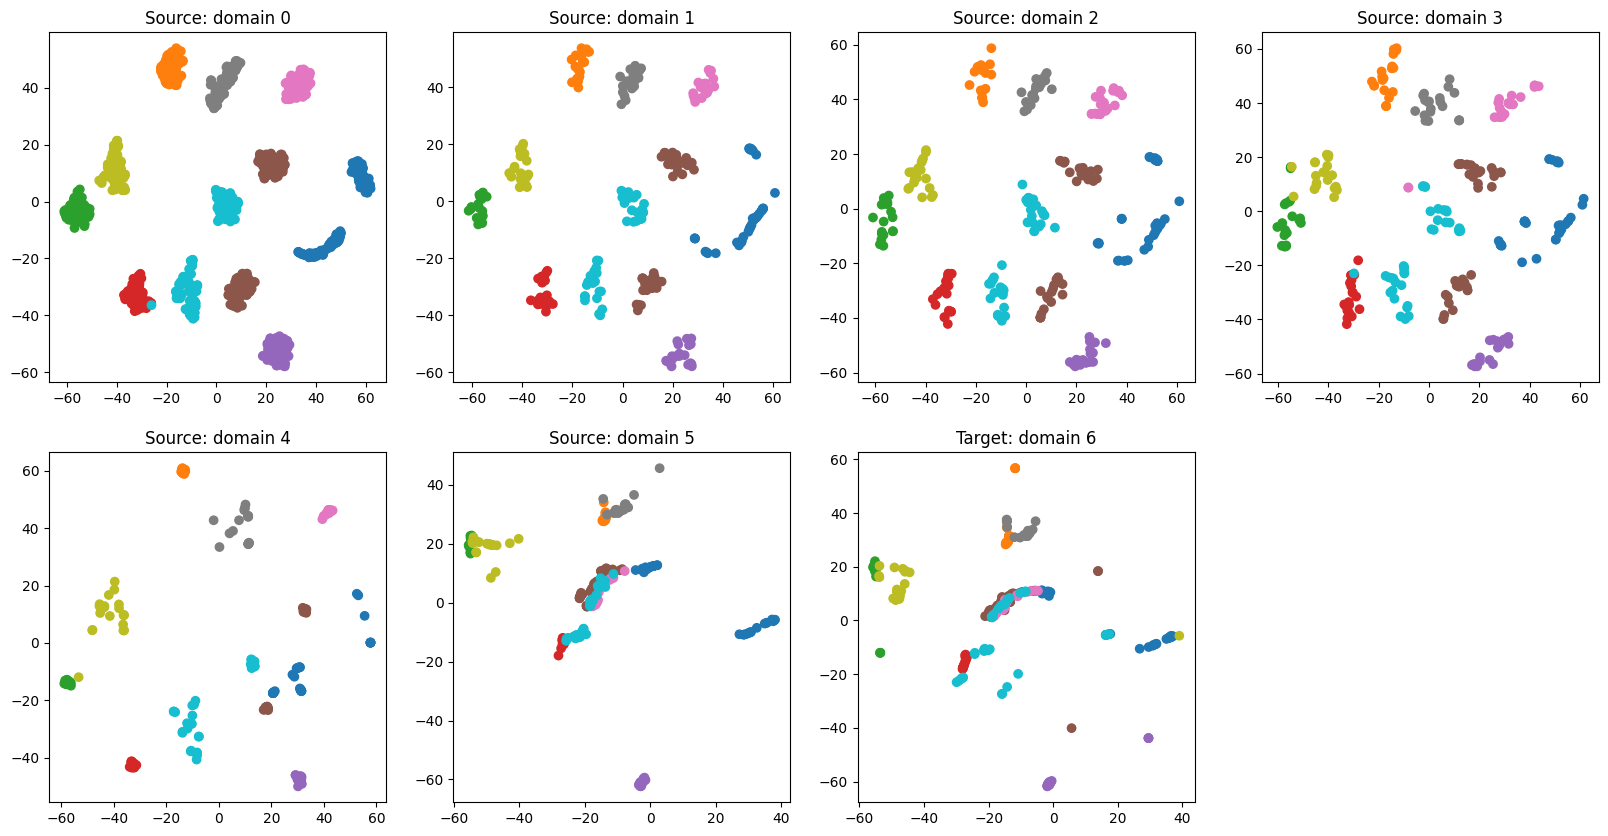

In [76]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [Xt], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()[:-1]):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys + [yt], dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')
        
axes.flatten()[-1].axis('off')

IndexError: index 2601 is out of bounds for dimension 0 with size 2600

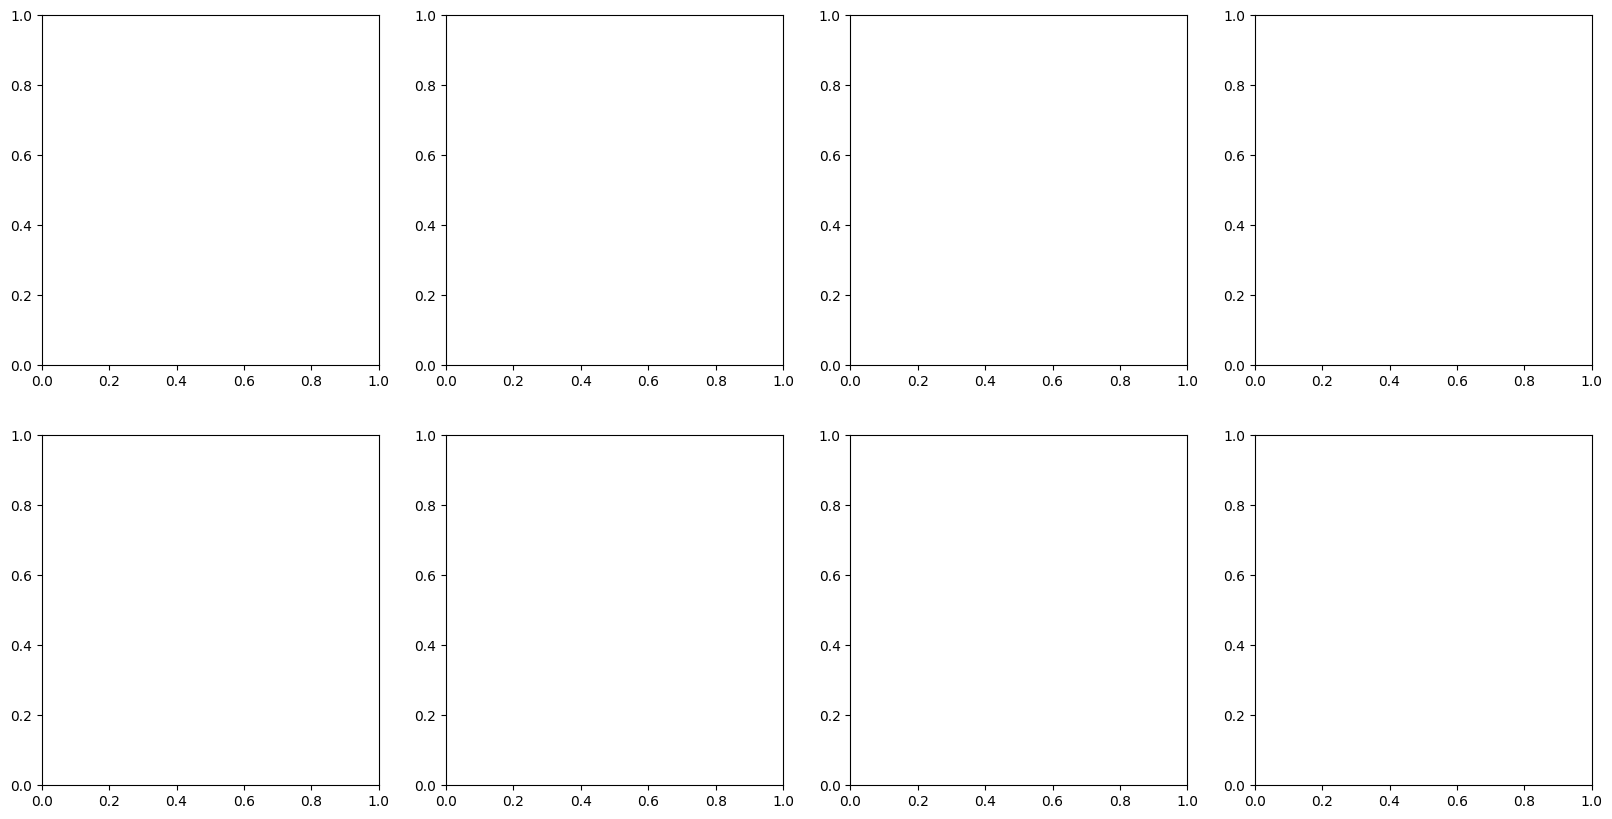

In [28]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [OGMM.sample(260)[0]], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()[:-2]):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys, dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')
ind = np.where(d == 6)[0]
axes.flatten()[-2].scatter(proj[ind, 0],
               proj[ind, 1])
axes.flatten()[-1].axis('off')

(0.0, 1.0, 0.0, 1.0)

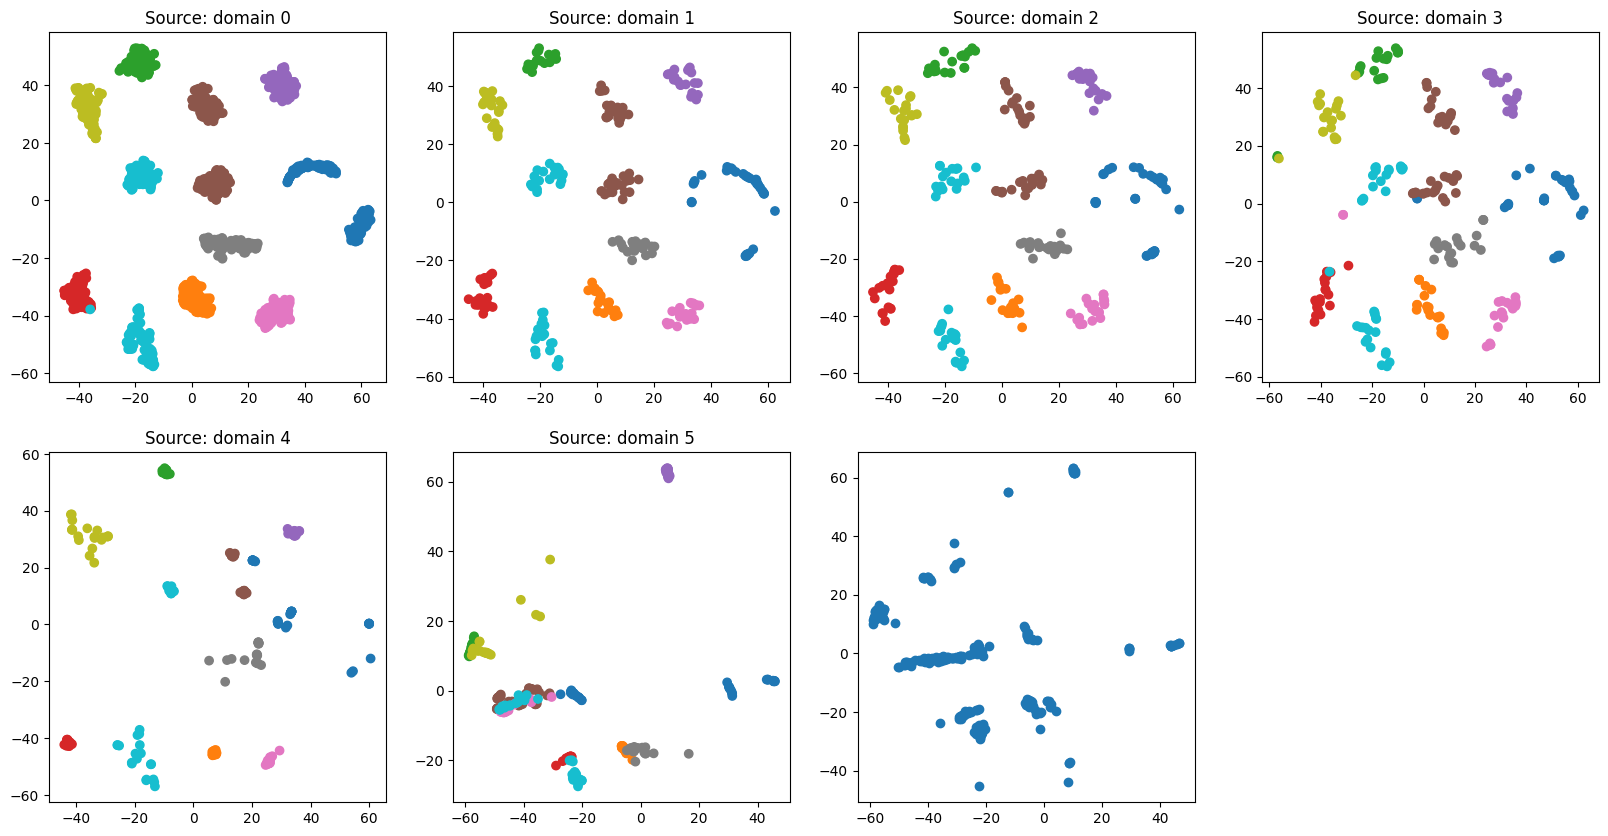

In [ ]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [torch.from_numpy(sklearn_GMM.sample(260)[0]).float()], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()[:-2]):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys, dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')
ind = np.where(d == 6)[0]
axes.flatten()[-2].scatter(proj[ind, 0],
               proj[ind, 1])
axes.flatten()[-1].axis('off')

Test to determine the best K_max

In [16]:
%%script false --no-exec
range_data = np.mean(np.max(X[np.where(d!=6)[0], :], axis=0) - np.min(X[np.where(d!=6)[0], :], axis=0))

K_max = np.linspace(13, 63, 11)
ll = []
for kmax in K_max:
    OGMM = Online_GMM(
        n_components=kmax, 
        lr=0.1,
        n_features=dim_reduction,
        data_range=range_data,
        batch_size=batch_size
    )
    
    i = 0
    while i < X_train_target_t.shape[0]-dim_reduction:
        OGMM.fit_sample(X_train_target_t[i:i+dim_reduction, :], dimension_reduction=True)
        i += dim_reduction

    print(OGMM.generate_list())
    ll.append(OGMM.log_likelihood(X_test_target_t, dimension_reduction=True))

Couldn't find program: 'false'


## Dictionary learning seperated between sources and target with Online_GMM simultaneously

In [11]:
Q_sources = []
for Xs_k, ys_k in zip(Xs, ys):
    Q_sources.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )

In [12]:
criterion = JointWassersteinDistance()

In [13]:
dictionary_sources = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q_sources),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [14]:
dictionary_sources.fit(Q_sources,
               n_iter_max=40,
               batches_per_it=n_samples // batch_size,
               verbose=True)

It 1/40, Loss: 104.3034423828125
It 2/40, Loss: 47.82797546386719
It 3/40, Loss: 20.90001029968262
It 4/40, Loss: 9.494852638244629
It 5/40, Loss: 4.650838994979858
It 6/40, Loss: 2.8243740081787108
It 7/40, Loss: 1.893705892562866
It 8/40, Loss: 1.4056312799453736
It 9/40, Loss: 1.054616594314575
It 10/40, Loss: 0.8566391110420228
It 11/40, Loss: 0.7138846516609192
It 12/40, Loss: 0.6432928681373596
It 13/40, Loss: 0.5929354906082154
It 14/40, Loss: 0.5521503567695618
It 15/40, Loss: 0.5241983294486999
It 16/40, Loss: 0.5040428757667542
It 17/40, Loss: 0.4964260041713715
It 18/40, Loss: 0.48107441067695617
It 19/40, Loss: 0.46560618877410886
It 20/40, Loss: 0.4500003635883332
It 21/40, Loss: 0.4416120648384094
It 22/40, Loss: 0.40647986531257635
It 23/40, Loss: 0.37803841233253477
It 24/40, Loss: 0.33658492565155024
It 25/40, Loss: 0.28704068064689636
It 26/40, Loss: 0.2440618872642517
It 27/40, Loss: 0.23247491717338561
It 28/40, Loss: 0.2107108622789383
It 29/40, Loss: 0.20570443868

In [15]:
XP_sources = dictionary_sources.XP
YP_sources = dictionary_sources.YP

In [16]:
names_sources = [f'domain {i}' for i in range(6)]

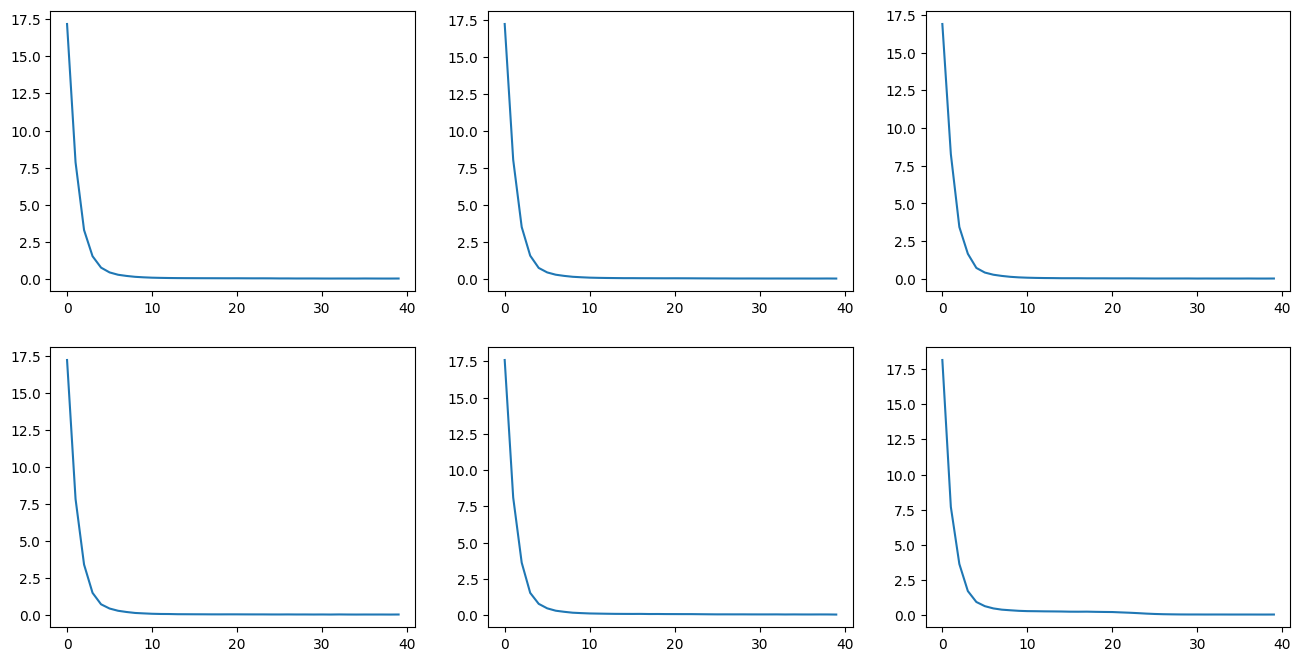

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for k, dom in enumerate(dictionary_sources.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary_sources.history['loss_per_dataset'][dom])

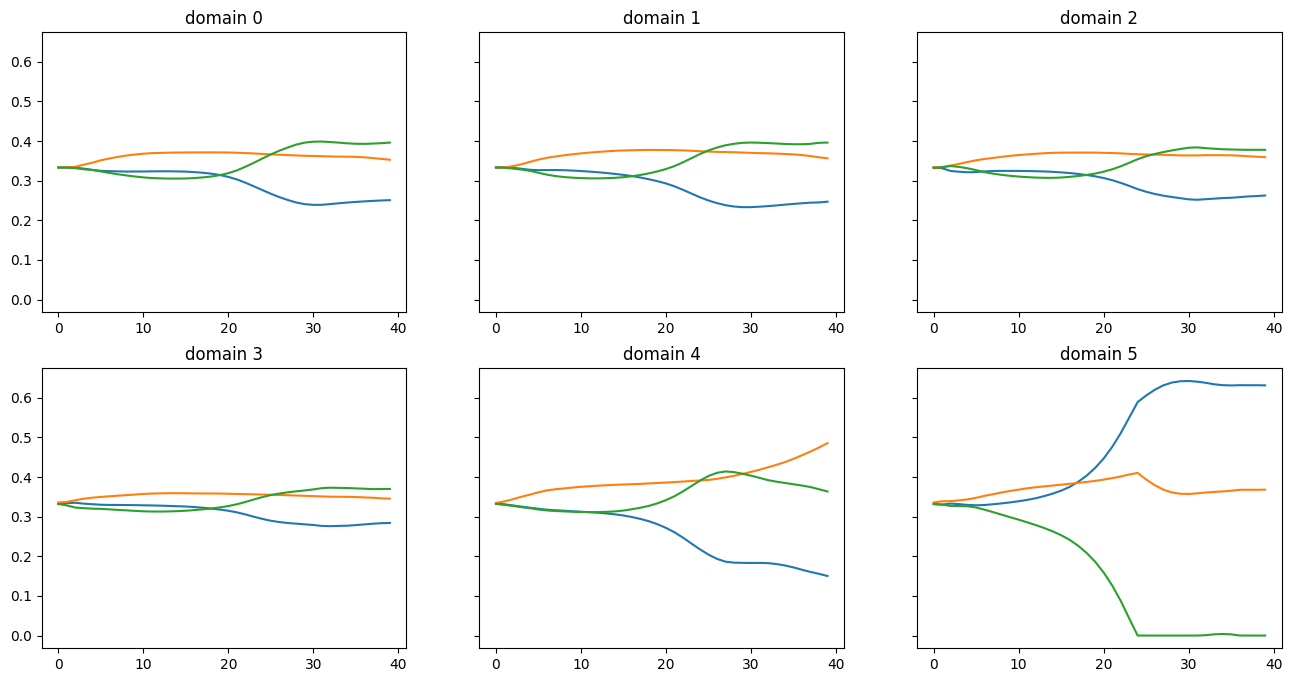

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names_sources, axes.flatten())):
    ax.plot(torch.stack(dictionary_sources.history['weights'])[:, k, :])
    ax.set_title(name)

In [19]:
dictionary_target = LabeledDictionaryGMM(XP=XP_sources,
                           YP=YP_sources,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=1,
                           loss_fn=criterion,
                           learning_rate_features=0,
                           learning_rate_labels=0,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False,
                           GMM_components=13,
                           GMM_dim_reduction=dim_reduction)

In [20]:
i = 0
while i < Xt.shape[0]-dim_reduction:
    print(i)
    dictionary_target.fit_target_sample(Xt[i:i+dim_reduction, :],
                                        batches_per_it=n_samples // batch_size,
                                        batch_size=batch_size,
                                        verbose=True,
                                        regularization=False,)
    i += dim_reduction

0
Loss: 0.5713636636734009
3
Loss: 0.5192826986312866
6
Loss: 0.5089853405952454
9
Loss: 0.5031739175319672
12
Loss: 0.4711758852005005
15
Loss: 0.42465495467185976
18
Loss: 0.4279787063598633
21
Loss: 0.313974928855896
24
Loss: 0.2660425066947937
27
Loss: 0.25323816835880275
30
Loss: 0.24052853882312775
33
Loss: 0.25075757205486293
36
Loss: 0.2502184122800827
39
Loss: 0.21197923719882966
42
Loss: 0.26405746638774874
45
Loss: 0.3537712097167969
48
Loss: 0.4858809769153595
51
Loss: 0.39066843986511235
54
Loss: 0.4440309822559357
57
Loss: 0.42956237792968754
60
Loss: 0.313650518655777
63
Loss: 0.30161301493644715
66
Loss: 0.37084013819694517
69
Loss: 0.3567562818527221
72
Loss: 0.37883596420288085
75
Loss: 0.3951745927333831
78
Loss: 0.362553882598877
81
Loss: 0.2346805542707443
84
Loss: 0.2790321230888367
87
Loss: 0.2684653401374817
90
Loss: 0.28479529619216915
93
Loss: 0.3230206489562988
96
Loss: 0.3701758503913879
99
Loss: 0.3157445073127746
102
Loss: 0.24968915879726408
105
Loss: 0.2

In [21]:
target_name = 'Domain 7'

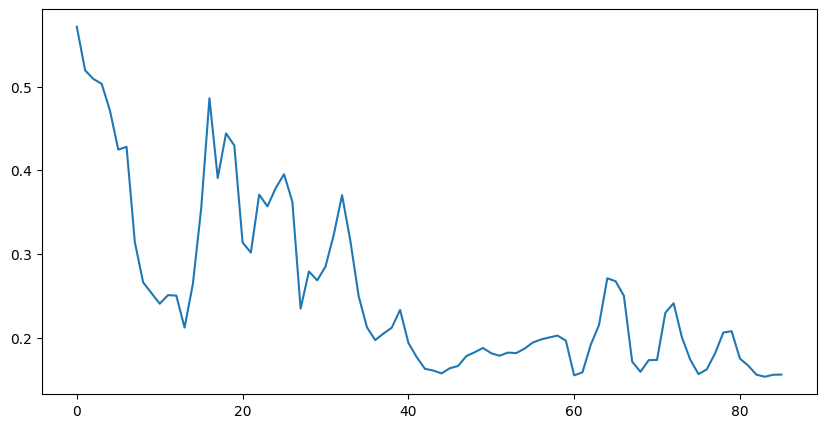

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dictionary_target.history['loss_per_dataset']['Domain 0'])

Text(0.5, 1.0, 'Domain 7')

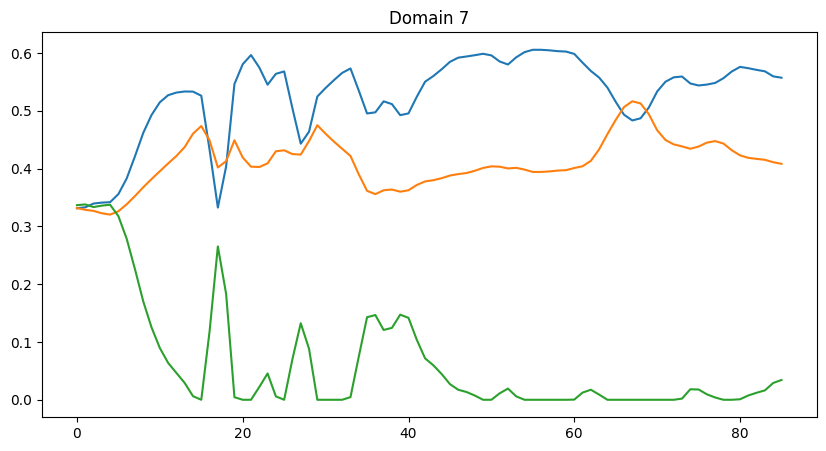

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(torch.stack(dictionary_target.history['weights'])[:, 0, :])
ax.set_title(target_name)

(0.0, 1.0, 0.0, 1.0)

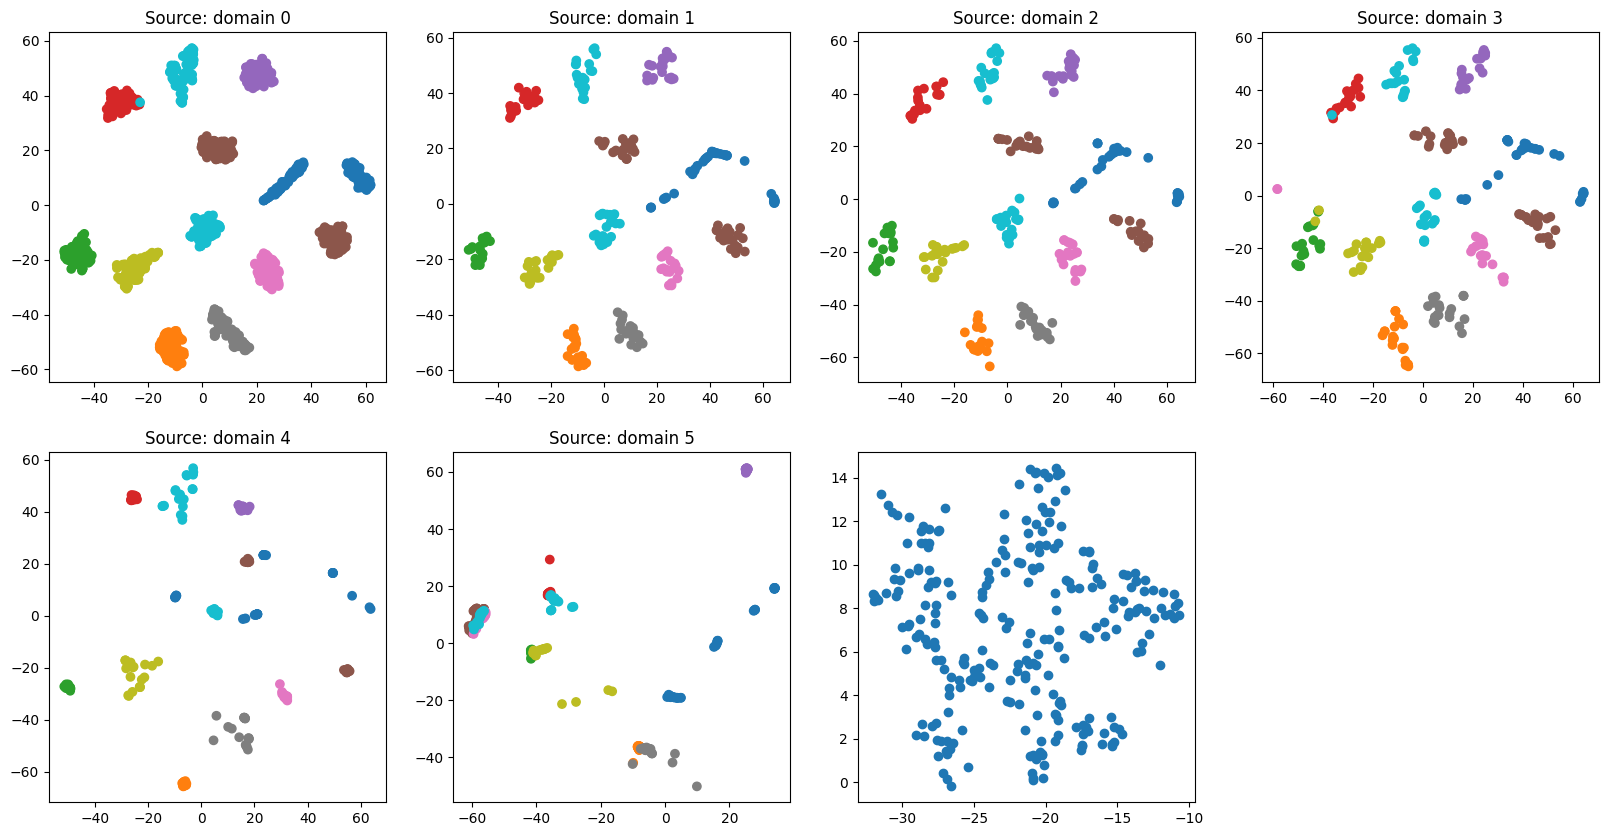

In [24]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [dictionary_target.OGMM.sample(260)[0]], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()[:-2]):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys, dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')
ind = np.where(d == 6)[0]
axes.flatten()[-2].scatter(proj[ind, 0],
               proj[ind, 1])
axes.flatten()[-1].axis('off')

In [25]:
weights = dictionary_target.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary_target.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary_target.YP]

tensor([0.5574, 0.4084, 0.0342])


In [64]:
Xr, Yr = dictionary_target.reconstruct(weights=weights)
Xt_OGMM = dictionary_target.OGMM.sample(Xr.shape[0])[0]

weights_r = torch.ones(Xr.shape[0])/Xr.shape[0]
weights_ogmm = torch.ones(Xt_OGMM.shape[0])/Xt_OGMM.shape[0]

C = torch.cdist(Xr, Xt_OGMM, p=2) ** 2
ot_plan = ot.emd(weights_r, weights_ogmm, C, numItermax=1000000)
Yt_OGMM = ot_plan.T @ Yr

In [70]:
clf = SVC(kernel='linear')
clf = RandomForestClassifier(criterion='gini')

clf.fit(Xt_OGMM, Yt_OGMM.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.45


Classification without DA

In [33]:
#clf = SVC(kernel='rbf')
clf = RandomForestClassifier()

clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.8115384615384615


DaDiL-E

In [38]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier(criterion='gini')

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.5569999814033508 got 0.6192307692307693
Atom 1 w/ weight 0.40799999237060547 got 0.5230769230769231
Atom 2 w/ weight 0.03400000184774399 got 0.3
0.6653846153846154


DaDiL-R

In [43]:
#clf = SVC(kernel='rbf')
clf = RandomForestClassifier(criterion='gini')

clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.7384615384615385


## Dictionary learning seperated between sources and target

In [12]:
Q_sources = []
for Xs_k, ys_k in zip(Xs, ys):
    Q_sources.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q_target = [UnsupervisedDatasetMeasure(
        features=Xt.numpy(),
        batch_size=batch_size,
        device='cpu'
    )]

Q_sources_and_target = Q_sources + Q_target

In [13]:
criterion = JointWassersteinDistance()

In [14]:
dictionary_sources = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q_sources),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [15]:
dictionary_sources.fit(Q_sources,
               n_iter_max=40,
               batches_per_it=n_samples // batch_size,
               verbose=True)

It 1/40, Loss: 107.81039581298829
It 2/40, Loss: 47.93586883544922
It 3/40, Loss: 20.238505935668943
It 4/40, Loss: 9.233237838745117
It 5/40, Loss: 4.725426149368285
It 6/40, Loss: 2.8308901786804195
It 7/40, Loss: 1.8424681901931765
It 8/40, Loss: 1.3619282245635984
It 9/40, Loss: 1.051264750957489
It 10/40, Loss: 0.8397273778915406
It 11/40, Loss: 0.7283247232437134
It 12/40, Loss: 0.6432579517364503
It 13/40, Loss: 0.5925328016281128
It 14/40, Loss: 0.5508150935173035
It 15/40, Loss: 0.5314950466156005
It 16/40, Loss: 0.5099714934825897
It 17/40, Loss: 0.49843987822532654
It 18/40, Loss: 0.4940301239490509
It 19/40, Loss: 0.48188315629959105
It 20/40, Loss: 0.4832151114940643
It 21/40, Loss: 0.4782568037509918
It 22/40, Loss: 0.46952807307243344
It 23/40, Loss: 0.45897586345672603
It 24/40, Loss: 0.44367960691452024
It 25/40, Loss: 0.4190539598464966
It 26/40, Loss: 0.39277009963989257
It 27/40, Loss: 0.35601717233657837
It 28/40, Loss: 0.3166005551815033
It 29/40, Loss: 0.26006163

In [16]:
XP_sources = dictionary_sources.XP
YP_sources = dictionary_sources.YP

In [17]:
names_sources = [f'domain {i}' for i in range(6)]

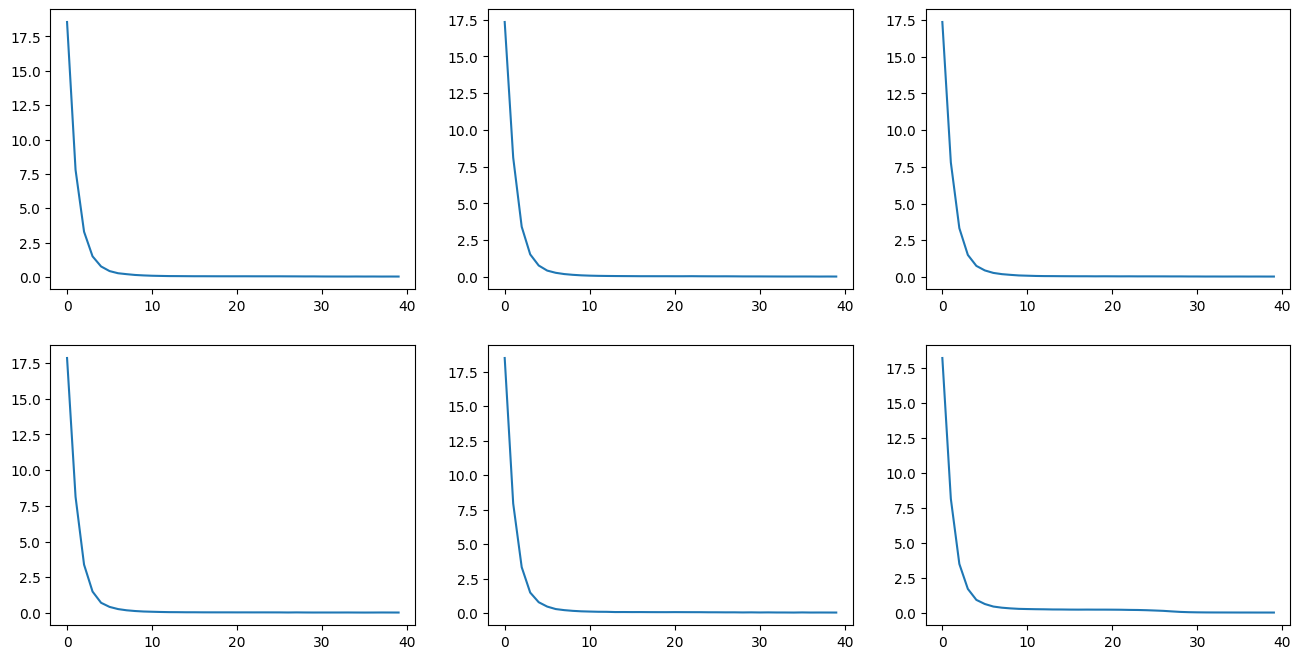

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for k, dom in enumerate(dictionary_sources.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary_sources.history['loss_per_dataset'][dom])

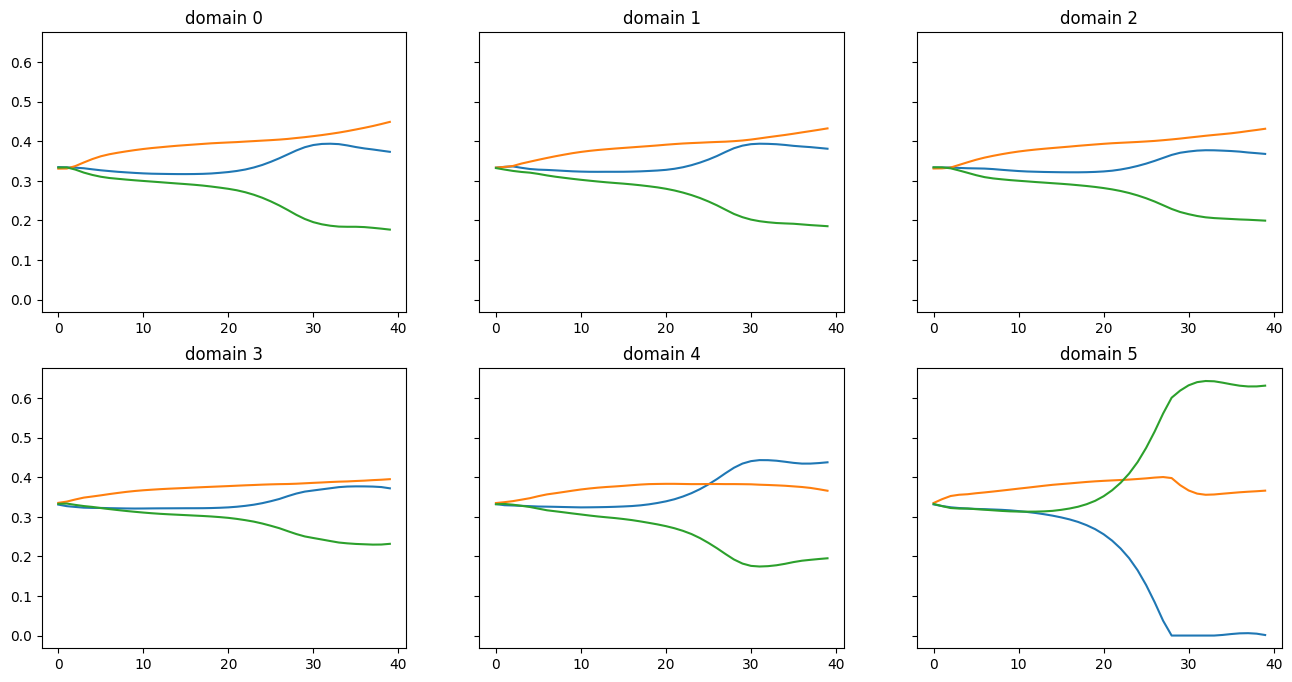

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names_sources, axes.flatten())):
    ax.plot(torch.stack(dictionary_sources.history['weights'])[:, k, :])
    ax.set_title(name)

In [20]:
dictionary_target = LabeledDictionaryGMM(XP=XP_sources,
                           YP=YP_sources,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q_target),
                           loss_fn=criterion,
                           learning_rate_features=0,
                           learning_rate_labels=0,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [21]:
dictionary_target.fit(Q_target,
               n_iter_max=40,
               batches_per_it=n_samples // batch_size,
               verbose=True,
               regularization=False)

It 1/40, Loss: 0.07545074597001075
It 2/40, Loss: 0.05891596749424935
It 3/40, Loss: 0.05004242956638336
It 4/40, Loss: 0.05029108896851539
It 5/40, Loss: 0.047944894433021544
It 6/40, Loss: 0.049110714346170425
It 7/40, Loss: 0.04850126802921296
It 8/40, Loss: 0.04696978777647019
It 9/40, Loss: 0.042833879590034485
It 10/40, Loss: 0.0396207794547081
It 11/40, Loss: 0.044060082733631135
It 12/40, Loss: 0.04535903558135032
It 13/40, Loss: 0.04865762367844582
It 14/40, Loss: 0.050921718776226046
It 15/40, Loss: 0.05110359638929367
It 16/40, Loss: 0.05177684724330902
It 17/40, Loss: 0.048094896227121355
It 18/40, Loss: 0.045425600558519366
It 19/40, Loss: 0.043093820661306376
It 20/40, Loss: 0.04607488214969635
It 21/40, Loss: 0.051322455704212185
It 22/40, Loss: 0.0497255951166153
It 23/40, Loss: 0.04670539721846581
It 24/40, Loss: 0.044034539163112646
It 25/40, Loss: 0.04439173191785812
It 26/40, Loss: 0.04023274630308151
It 27/40, Loss: 0.04917400777339936
It 28/40, Loss: 0.04778573513

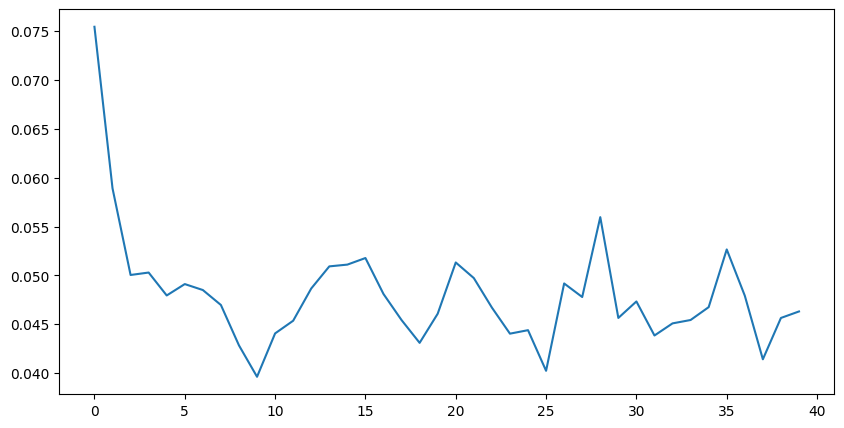

In [22]:
target_name = 'Domain 7'
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dictionary_target.history['loss_per_dataset']['Domain 0'])

Text(0.5, 1.0, 'Domain 7')

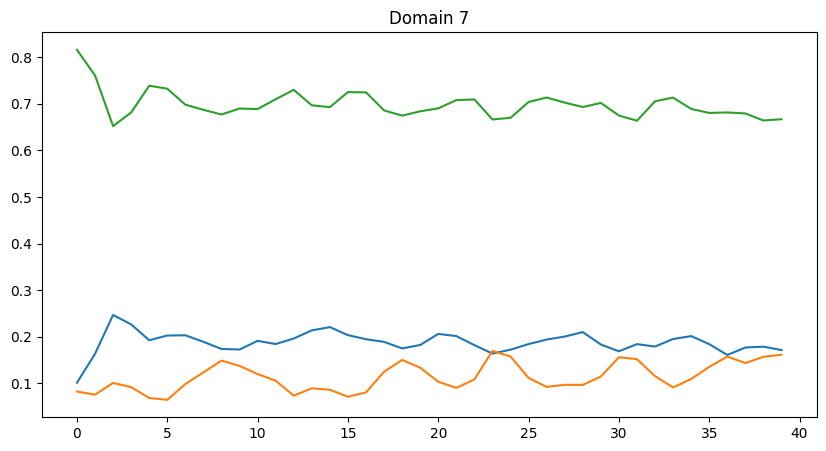

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(torch.stack(dictionary_target.history['weights'])[:, -1, :])
ax.set_title(target_name)

In [24]:
weights = dictionary_target.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary_target.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary_target.YP]

tensor([0.1716, 0.1615, 0.6669])


In [25]:
Xr, Yr = wasserstein_barycenter(
    XP=XP,
    YP=YP,
    n_samples=n_samples,
    weights=weights,
    tol=1e-9,
    n_iter_max=10,
    propagate_labels=True,
    penalize_labels=True
)

Classification without DA

In [37]:
#clf = SVC(kernel='linear')
clf = RandomForestClassifier(criterion = 'gini')
clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.8384615384615385


DaDiL-E

In [37]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier(criterion = 'gini')

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.1720000058412552 got 0.2846153846153846
Atom 1 w/ weight 0.16099999845027924 got 0.5346153846153846
Atom 2 w/ weight 0.6669999957084656 got 0.573076923076923
0.6038461538461538


DaDiL-R

In [34]:
clf = SVC(kernel='rbf')
#clf = RandomForestClassifier(criterion = 'gini')

clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.6961538461538461


## Classic Dictionary learning with Online_GMM

In [12]:
Q = []
for Xs_k, ys_k in zip(Xs, ys):
    Q.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q.append(sklearn_GMM)

In [13]:
criterion = JointWassersteinDistance()

In [14]:
dictionary = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [16]:
dictionary.fit(Q,
               n_iter_max=40,
               batches_per_it=n_samples // batch_size,
               verbose=True,
               sklearn_GMM=True)

It 1/40, Loss: 107.8121841430664
It 2/40, Loss: 47.54974899291992
It 3/40, Loss: 20.625340461730957
It 4/40, Loss: 9.278345489501952
It 5/40, Loss: 4.763325309753418
It 6/40, Loss: 2.897550582885742
It 7/40, Loss: 2.048203682899475
It 8/40, Loss: 1.5235420942306517
It 9/40, Loss: 1.226585364341736
It 10/40, Loss: 0.9969257950782777
It 11/40, Loss: 0.8685607194900513
It 12/40, Loss: 0.7871431350708008
It 13/40, Loss: 0.7067089915275573
It 14/40, Loss: 0.6545913577079772
It 15/40, Loss: 0.6036144256591797
It 16/40, Loss: 0.556810986995697
It 17/40, Loss: 0.5010749518871307
It 18/40, Loss: 0.42699043154716493
It 19/40, Loss: 0.3566938281059265
It 20/40, Loss: 0.307956200838089
It 21/40, Loss: 0.2713850378990173
It 22/40, Loss: 0.2560898691415787
It 23/40, Loss: 0.254859808087349
It 24/40, Loss: 0.23855468928813936
It 25/40, Loss: 0.2253258854150772
It 26/40, Loss: 0.24072986245155337
It 27/40, Loss: 0.222749200463295
It 28/40, Loss: 0.23448785245418546
It 29/40, Loss: 0.22915458381175993


In [17]:
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

(0.0, 1.0, 0.0, 1.0)

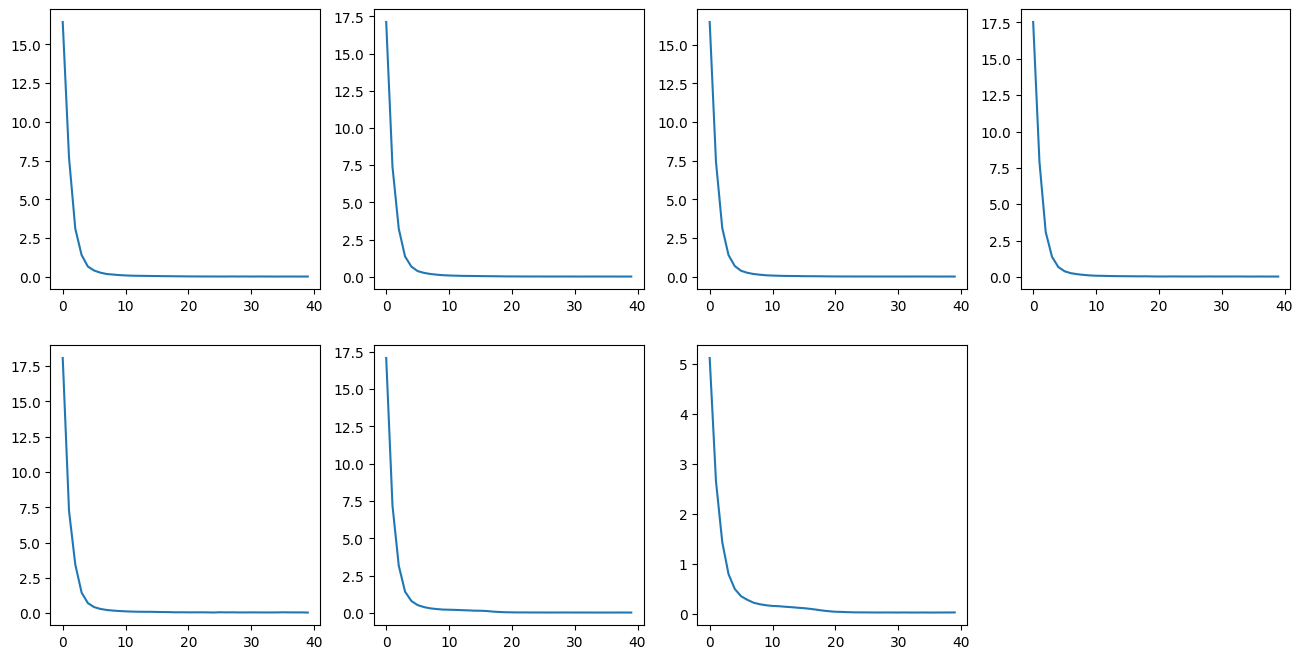

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for k, dom in enumerate(dictionary.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary.history['loss_per_dataset'][dom])
axes.flatten()[-1].axis('off')

(0.0, 1.0, 0.046072678267955774, 0.6868106260895729)

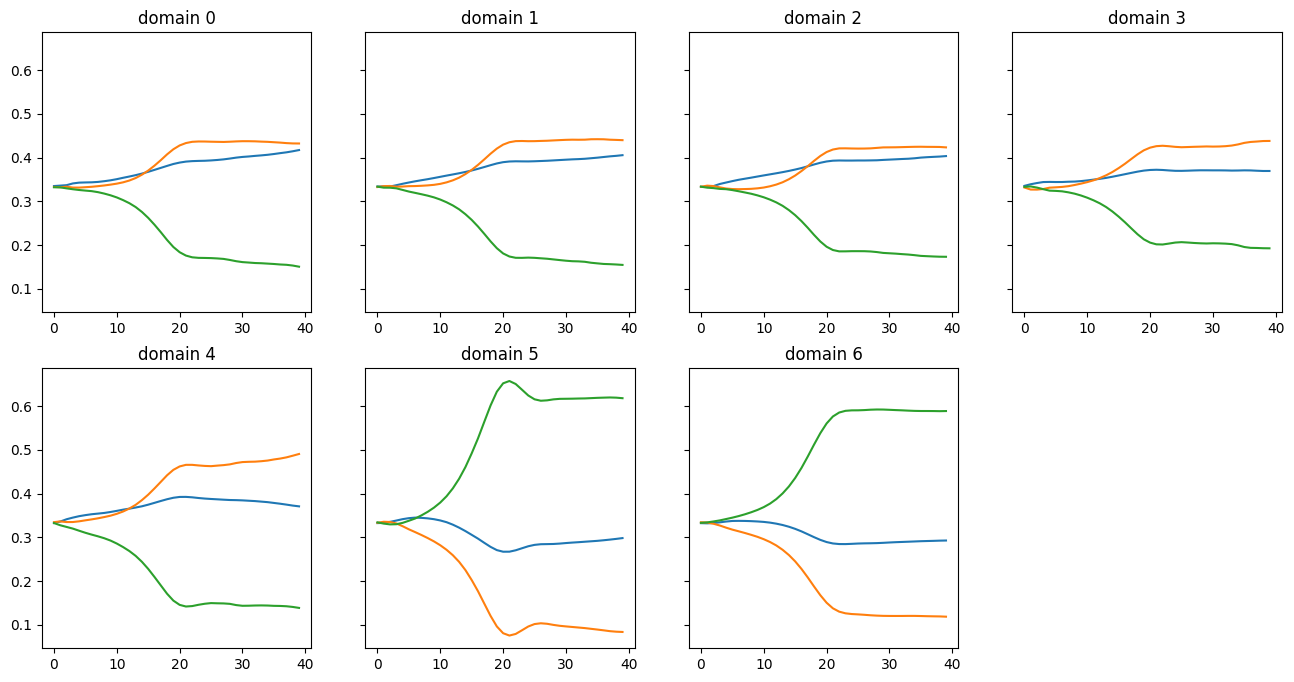

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names, axes.flatten())):
    ax.plot(torch.stack(dictionary.history['weights'])[:, k, :])
    ax.set_title(name)
axes.flatten()[-1].axis('off')

In [20]:
weights = dictionary.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary.YP]

tensor([0.2927, 0.1184, 0.5889])


In [21]:
Xr, Yr = wasserstein_barycenter(
    XP=XP,
    YP=YP,
    n_samples=n_samples,
    weights=weights,
    tol=1e-9,
    n_iter_max=10,
    propagate_labels=True,
    penalize_labels=True
)

Classification without DA

In [22]:
#clf = SVC(kernel='rbf')
clf = RandomForestClassifier()
#clf = KNeighborsClassifier()
#clf = GaussianProcessClassifier()
#clf = DecisionTreeClassifier(criterion='entropy')

clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.8153846153846154


DaDiL-E

In [37]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier()

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.2930000126361847 got 0.5384615384615384
Atom 1 w/ weight 0.11800000071525574 got 0.36538461538461536
Atom 2 w/ weight 0.5889999866485596 got 0.5653846153846154
0.5653846153846154


DaDiL-R

In [30]:
clf = SVC(kernel='rbf')
clf = RandomForestClassifier()

clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.8076923076923077


In [ ]:
Xr, Yr = dictionary_target.reconstruct(weights=weights)
Xt_OGMM = dictionary_target.OGMM.sample(Xr.shape[0])[0]

weights_r = torch.ones(Xr.shape[0])/Xr.shape[0]
weights_ogmm = torch.ones(Xt_OGMM.shape[0])/Xt_OGMM.shape[0]

C = torch.cdist(Xr, Xt_OGMM, p=2) ** 2
ot_plan = ot.emd(weights_r, weights_ogmm, C, numItermax=1000000)
Yt_OGMM = ot_plan.T @ Yr

clf = SVC(kernel='linear')
clf = RandomForestClassifier(criterion='gini')

clf.fit(Xt_OGMM, Yt_OGMM.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

In [ ]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier()

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    Xt_OGMM = dictionary_target.OGMM.sample(XP_k.shape[0])[0]

    weights_k = torch.ones(XP_k.shape[0])/XP_k.shape[0]
    weights_ogmm = torch.ones(Xt_OGMM.shape[0])/Xt_OGMM.shape[0]

    C = torch.cdist(XP_k, Xt_OGMM, p=2) ** 2
    ot_plan = ot.emd(weights_k, weights_ogmm, C, numItermax=1000000)
    Yt_OGMM = ot_plan.T @ YP_k

    yt_ogmm = Yt_OGMM.argmax(dim=1)
    
    clf.fit(Xt_OGMM, yt_ogmm)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

## Classic Dictionary Learning

In [13]:
Q = []
for Xs_k, ys_k in zip(Xs, ys):
    Q.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q.append(
    UnsupervisedDatasetMeasure(
        features=Xt.numpy(),
        batch_size=batch_size,
        device='cpu'
    )
)

In [14]:
criterion = JointWassersteinDistance()

In [15]:
dictionary = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [16]:
dictionary.fit(Q,
               n_iter_max=60,
               batches_per_it=n_samples // batch_size,
               verbose=True)

It 1/60, Loss: 106.3423797607422
It 2/60, Loss: 48.070806121826166
It 3/60, Loss: 20.678227996826173
It 4/60, Loss: 9.285503673553468
It 5/60, Loss: 4.748308563232422
It 6/60, Loss: 2.865239715576172
It 7/60, Loss: 2.0727163553237915
It 8/60, Loss: 1.537552213668823
It 9/60, Loss: 1.2142271995544434
It 10/60, Loss: 1.0122873783111572
It 11/60, Loss: 0.865707790851593
It 12/60, Loss: 0.7957367658615113
It 13/60, Loss: 0.7346983909606934
It 14/60, Loss: 0.6939870953559876
It 15/60, Loss: 0.6741306781768798
It 16/60, Loss: 0.6584912776947022
It 17/60, Loss: 0.6333697319030762
It 18/60, Loss: 0.6254691362380982
It 19/60, Loss: 0.6122795581817627
It 20/60, Loss: 0.5864691615104676
It 21/60, Loss: 0.5417202711105347
It 22/60, Loss: 0.5093261659145355
It 23/60, Loss: 0.44465949535369875
It 24/60, Loss: 0.3759253084659576
It 25/60, Loss: 0.31462734341621396
It 26/60, Loss: 0.2882290780544281
It 27/60, Loss: 0.2533076643943787
It 28/60, Loss: 0.25117858350276945
It 29/60, Loss: 0.23932412862777

In [17]:
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

(0.0, 1.0, 0.0, 1.0)

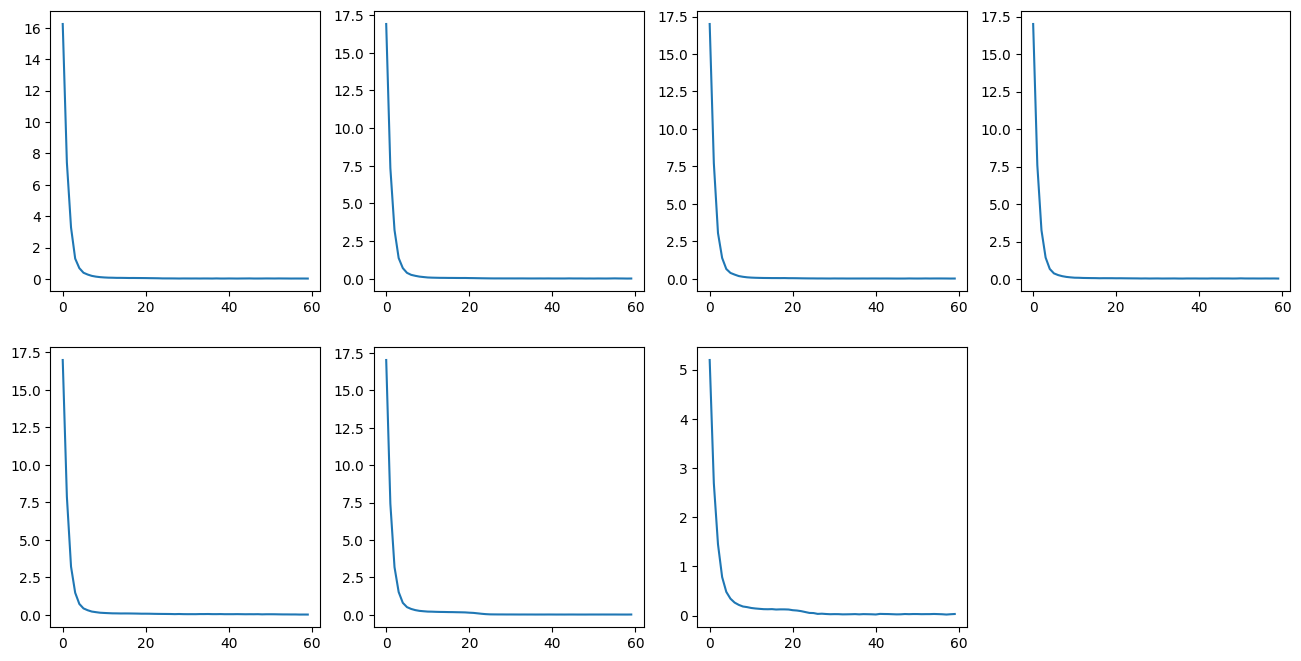

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for k, dom in enumerate(dictionary.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary.history['loss_per_dataset'][dom])
axes.flatten()[-1].axis('off')

(0.0, 1.0, 0.09289187900722026, 0.7199628207832575)

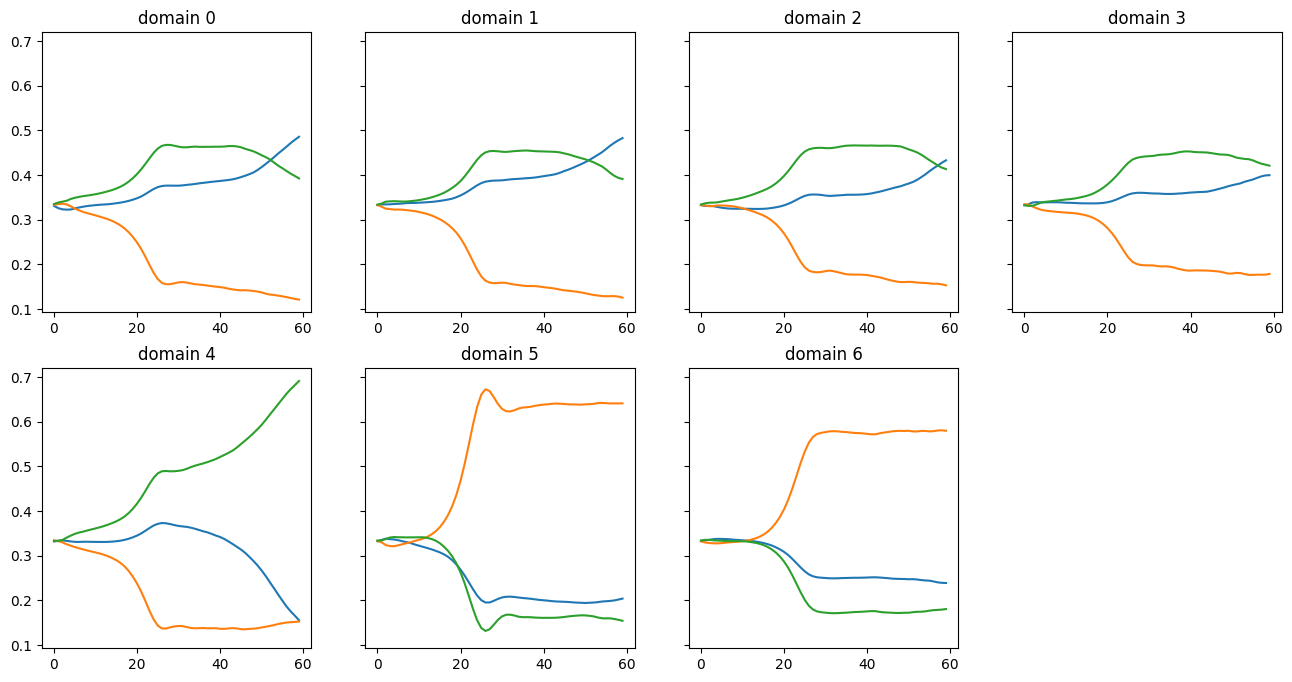

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names, axes.flatten())):
    ax.plot(torch.stack(dictionary.history['weights'])[:, k, :])
    ax.set_title(name)
axes.flatten()[-1].axis('off')

In [20]:
weights = dictionary.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary.YP]

tensor([0.2391, 0.5802, 0.1808])


In [21]:
Xr, Yr = wasserstein_barycenter(
    XP=XP,
    YP=YP,
    n_samples=n_samples,
    weights=weights,
    tol=1e-9,
    n_iter_max=10,
    propagate_labels=True,
    penalize_labels=True
)

Classification without DA

In [33]:
#clf = SVC(kernel='rbf')
clf = RandomForestClassifier()

clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.8538461538461538


DaDiL-E

In [56]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier()

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.23899999260902405 got 0.4576923076923077
Atom 1 w/ weight 0.5799999833106995 got 0.5461538461538461
Atom 2 w/ weight 0.1809999942779541 got 0.4230769230769231
0.55


DaDiL-R

In [62]:
#clf = SVC(kernel='rbf')
clf = RandomForestClassifier(criterion='entropy')

clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.7846153846153846
